In [148]:
import pandas as pd
import matplotlib.pyplot as plt
# Load the CSV files
pre_may_2017_df = pd.read_csv('https://raw.githubusercontent.com/rhobaker/Data_Project/main/Historical%20Tobacco%20Duty%20rates/clean_historical_tobacco_duty_pre_may_2017.csv')
post_may_2017_df = pd.read_csv('https://raw.githubusercontent.com/rhobaker/Data_Project/main/Historical%20Tobacco%20Duty%20rates/clean_historical_tobacco_duty_post_may_2017.csv')

In [149]:
price_url = 'https://raw.githubusercontent.com/rhobaker/Data_Project/main/ONS_av_price_cigarettes_king_size_filter/Cleaned_ONS_av_price_cigarettes_king_size_filterce_cigarettes_king_size.csv'

price = pd.read_csv(price_url)

In [150]:
price['Price in £'] = price['Pence'] / 100

In [151]:
# Ensure 'Date' columns are datetime types
# Ensure 'Date of change' columns are datetime types without converting parsing errors to NaT
pre_may_2017_df['Date of change'] = pd.to_datetime(pre_may_2017_df['Date of change'], format='%Y-%m-%d')
post_may_2017_df['Date of change'] = pd.to_datetime(post_may_2017_df['Date of change'], format='%Y-%m-%d')

In [152]:
#Drop columns not needed
pre_may_2017_df.drop(columns=['Cigars £ per kg', 'HRT £ per kg', 'Other £ per kg'], inplace=True)
post_may_2017_df.drop(columns=['Cigars £ per kg', 'HRT £ per kg', 'Other £ per kg'], inplace=True)


In [153]:
combined_df = pd.concat([pre_may_2017_df, post_may_2017_df]).sort_values(by='Date of change').reset_index(drop=True)


In [154]:
import numpy as np
import pandas as pd

# Extract year from 'Date of change' column in combined_df
combined_df['Year'] = combined_df['Date of change'].dt.year

# Merge price with combined_df based on year and align prices
combined_df = combined_df.merge(price, how='left', left_on='Year', right_on='year')

# Create 'Retail price of King size pack in £' column
combined_df['Retail price of King size pack in £'] = np.where(combined_df['Year'] == combined_df['year'], combined_df['Price in £'], np.nan)

combined_df.drop(columns=['year', 'Price in £', 'Pence', 'Year'], inplace=True)

# Resulting DataFrame
print(combined_df)

   Date of change  Cigarettes ad valorem (%)  Specific £ per 1000 sticks  \
0      1978-01-01                       30.0                        9.00   
1      1979-08-13                       21.0                       11.77   
2      1980-03-29                       21.0                       13.42   
3      1981-03-14                       21.0                       18.04   
4      1981-07-08                       21.0                       19.03   
5      1982-03-12                       21.0                       20.68   
6      1983-03-18                       21.0                       21.67   
7      1984-03-16                       21.0                       24.97   
8      1985-03-22                       21.0                       26.95   
9      1986-03-21                       21.0                       30.61   
10     1988-03-18                       21.0                       31.74   
11     1990-03-23                       21.0                       34.91   
12     1991-

In [155]:
import numpy as np

def calculate_duty(date):

    # Get the retail price for the given date
    retail_price = combined_df.loc[combined_df['Date of change'] == date, 'Retail price of King size pack in £'].iloc[0]
    
    # Check if the retail price is NaN
    if pd.isna(retail_price):
        return np.nan

    cigarettes_per_pack = 20

    if date < pd.to_datetime('2017-05-20'):
        # Historical duty pre-May 2017
        if not pre_may_2017_df.empty:
            pre_may_rows = pre_may_2017_df[pre_may_2017_df['Date of change'] <= date]
            if not pre_may_rows.empty:
                row = pre_may_rows.iloc[-1]
                specific_duty_per_pack = row['Specific £ per 1000 sticks'] / 50  # Adjusted duty for a pack
                ad_valorem_percentage = pd.to_numeric(row['Cigarettes ad valorem (%)'], errors='coerce')  # Adjusted column name here

                # Calculate the percentage duty for a pack
                percentage_duty = ad_valorem_percentage / 100 * retail_price

                # Total duty for a pack
                total_duty = percentage_duty + specific_duty_per_pack
            else:
                total_duty = 0  # No historical data available
        else:
            total_duty = 0  # No historical data available
    else:
        # Duty post-May 2017
        if not post_may_2017_df.empty:
            post_may_rows = post_may_2017_df[post_may_2017_df['Date of change'] <= date]
            if not post_may_rows.empty:
                row = post_may_rows.iloc[-1]
                specific_duty_per_pack = row['Specific £ per 1000 sticks'] / 50  # Adjusted duty for a pack
                minimum_excise_tax_per_pack = row['Minimum excise tax £ per 1000 sticks'] / 50  # Adjusted column name here
                ad_valorem_percentage = pd.to_numeric(row['Cigarettes ad valorem (%)'], errors='coerce')  # Adjusted column name here
                
                # Calculate the percentage duty for a pack
                percentage_duty = ad_valorem_percentage / 100 * retail_price

                # Total duty for a pack using specific duty plus percentage
                total_duty_1 = round(percentage_duty + specific_duty_per_pack, 2)
                # Total duty for a pack using minimum excise tax
                total_duty_2 = minimum_excise_tax_per_pack

                # Take the higher of the two total duties
                total_duty = max(total_duty_1, total_duty_2)
            else:
                total_duty = 0  # No post-May 2017 data available
        else:
            total_duty = 0  # No post-May 2017 data available

    return round(total_duty,2)

In [157]:
combined_df['Duty'] = combined_df['Date of change'].apply(lambda x: calculate_duty(x))

Calculating duty for: 1978-01-01 00:00:00
Calculating duty for: 1979-08-13 00:00:00
Calculating duty for: 1980-03-29 00:00:00
Calculating duty for: 1981-03-14 00:00:00
Calculating duty for: 1981-07-08 00:00:00
Calculating duty for: 1982-03-12 00:00:00
Calculating duty for: 1983-03-18 00:00:00
Calculating duty for: 1984-03-16 00:00:00
Calculating duty for: 1985-03-22 00:00:00
Calculating duty for: 1986-03-21 00:00:00
Calculating duty for: 1988-03-18 00:00:00
Calculating duty for: 1990-03-23 00:00:00
Calculating duty for: 1991-03-19 00:00:00
Calculating duty for: 1992-03-10 00:00:00
Calculating duty for: 1993-03-16 00:00:00
Calculating duty for: 1993-11-30 00:00:00
Calculating duty for: 1994-11-29 00:00:00
Calculating duty for: 1995-01-01 00:00:00
Calculating duty for: 1995-11-28 00:00:00
Calculating duty for: 1996-11-26 00:00:00
Calculating duty for: 1997-12-01 00:00:00
Calculating duty for: 1998-12-01 00:00:00
Calculating duty for: 1999-03-09 00:00:00
Calculating duty for: 2000-03-21 0

In [158]:
combined_df.head(50)

,Date of change,Cigarettes ad valorem (%),Specific £ per 1000 sticks,Minimum excise tax £ per 1000 sticks,TfH £ per kg,Retail price of King size pack in £,Duty
0,1978-01-01,30.0,9.00,NaN,NaN,NaN,NaN
1,1979-08-13,21.0,11.77,NaN,NaN,NaN,NaN
2,1980-03-29,21.0,13.42,NaN,NaN,NaN,NaN
3,1981-03-14,21.0,18.04,NaN,NaN,NaN,NaN
4,1981-07-08,21.0,19.03,NaN,NaN,NaN,NaN
5,1982-03-12,21.0,20.68,NaN,NaN,NaN,NaN
6,1983-03-18,21.0,21.67,NaN,NaN,NaN,NaN
7,1984-03-16,21.0,24.97,NaN,NaN,NaN,NaN
8,1985-03-22,21.0,26.95,NaN,NaN,NaN,NaN
9,1986-03-21,21.0,30.61,NaN,NaN,NaN,NaN


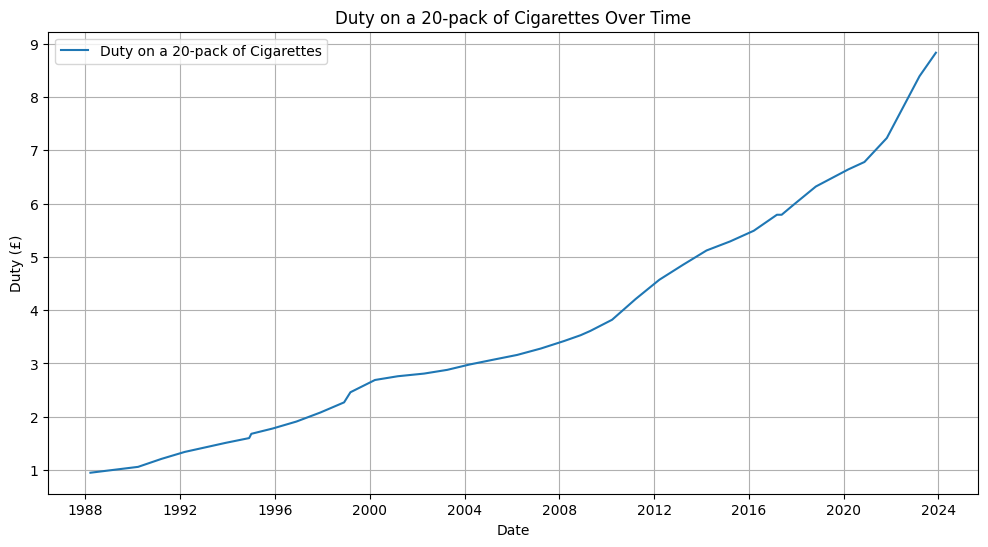

In [159]:
# Plotting the duty over time
plt.figure(figsize=(12, 6))
plt.plot(combined_df['Date of change'], combined_df['Duty'], label='Duty on a 20-pack of Cigarettes', color='tab:blue')
plt.xlabel('Date')
plt.ylabel('Duty (£)')
plt.title('Duty on a 20-pack of Cigarettes Over Time')
plt.legend()
plt.grid(True)
plt.show()

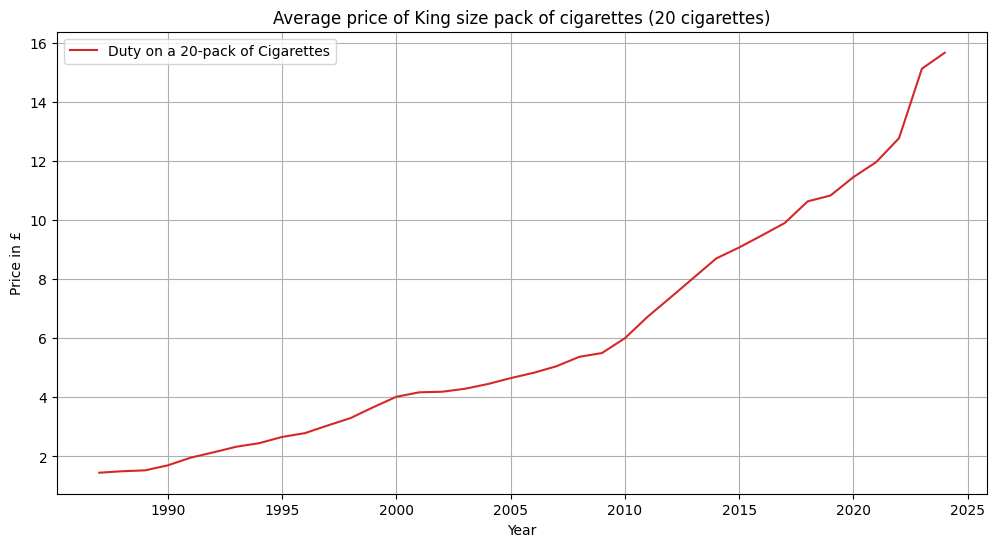

In [161]:
plt.figure(figsize=(12, 6))
plt.plot(price['year'], price['Price in £'], label='Duty on a 20-pack of Cigarettes', color='tab:red')
plt.xlabel('Year')
plt.ylabel('Price in £')
plt.title('Average price of King size pack of cigarettes (20 cigarettes)')
plt.legend()
plt.grid(True)
plt.show()